<a href="https://colab.research.google.com/github/MemphisMeng/FitStart/blob/main/Nike_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of SKU12345 in Q1, 2022

In this notebook, I am going to predict the sale of SKU-12345 in Quarter 1, 2022 based on its previous performance in 2020-2021. 

Majorly, time series analysis methods will be in use so a 3rd party package "sktime" is going to install at the beginning.

In [35]:
! pip install sktime
! pip install pmdarima

     |████████████████████████████████| 9.5 MB 3.9 MB/s 
  Using cached numpy-1.19.3-cp37-cp37m-manylinux2010_x86_64.whl (14.9 MB)


In [36]:
import pandas as pd

# historical data
sku_df = pd.read_csv('/content/SKU12345.csv')

In [85]:
sku_df['TRANS_DT'] = pd.to_datetime(sku_df['TRANS_DT'])
sku_df = sku_df.sort_values(by='TRANS_DT')

In [99]:
# the last day in record
sku_df.tail(1)

,GTIN,TRANS_DT,UNITS
706,SKU12345,2021-12-13,14


In [109]:
if sku_df.shape[0] < pd.date_range(start='1/1/2020', end='12/13/2021').shape[0]:
  print('Some data points are missing')

Some data points are missing


In [114]:
sku_df

,GTIN,TRANS_DT,UNITS
0,SKU12345,2020-01-01,73
1,SKU12345,2020-01-02,115
2,SKU12345,2020-01-03,155
3,SKU12345,2020-01-04,471
4,SKU12345,2020-01-05,155
...,...,...,...
702,SKU12345,2021-12-09,299
703,SKU12345,2021-12-10,359
704,SKU12345,2021-12-11,578
705,SKU12345,2021-12-12,379


In [116]:
# complete the timeline
complete_dt = pd.DataFrame({'TRANS_DT': pd.date_range(start='1/1/2020', end='12/13/2021')})
sku_df = complete_dt.merge(sku_df, on='TRANS_DT', how='left')

,TRANS_DT,GTIN,UNITS
0,2020-01-01,SKU12345,73.0
1,2020-01-02,SKU12345,115.0
2,2020-01-03,SKU12345,155.0
3,2020-01-04,SKU12345,471.0
4,2020-01-05,SKU12345,155.0
...,...,...,...
708,2021-12-09,SKU12345,299.0
709,2021-12-10,SKU12345,359.0
710,2021-12-11,SKU12345,578.0
711,2021-12-12,SKU12345,379.0


## The overview of the existing data

Daily plot

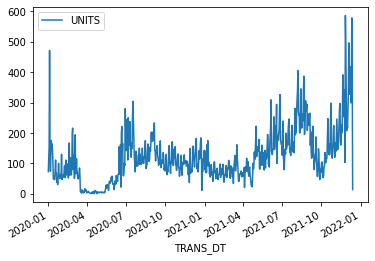

In [117]:
sku_df.plot(x='TRANS_DT', y='UNITS')

Quarterly plot

Text(0.5, 0, 'TRANS_DT(QUARTER)')

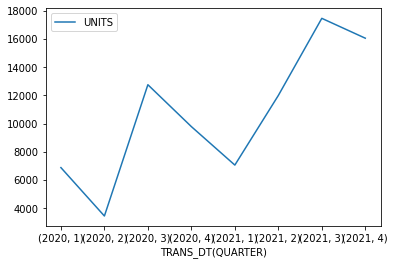

In [118]:
ax = sku_df.groupby([sku_df.TRANS_DT.dt.year, sku_df.TRANS_DT.dt.quarter]).sum().plot()
ax.set_xlabel('TRANS_DT(QUARTER)')

## Forecast

---
### Modeling
5 methods to compare:
* Naive forecaster: always pick the mean value among the previous data
* Trend Forecaster: Linear regression
* Polynomial Trend Forecaster: Polynomial regression
* Exponential Smoothing
* Auto ARIMA: moving average

The comparison criterion is MAPE (Mean absolute percentage error), which is expressed as:
$$M=\frac{1}{n}|\frac{A_t-F_t}{A_t}|$$,

where
* M = MAPE
* n = numbers of time
* $A_t$ = actual value
* $F_t$ = forecast value

The lower MAPE is, the better the performance of this model is.

In [40]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import TrendForecaster, PolynomialTrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
# for visualization
from sktime.utils.plotting import plot_series

In [119]:
# split the train/test sets
y = sku_df['UNITS']
y_train, y_test = temporal_train_test_split(y)

SCORE of Naive Forecaster: 0.6644540312041777


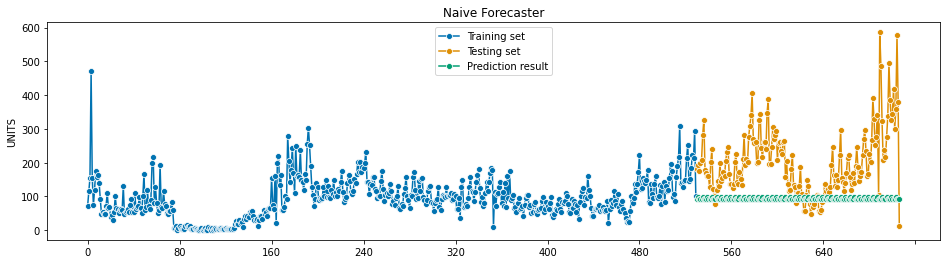

In [120]:
forecaster = NaiveForecaster(strategy='mean', sp=4)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh=[d for d in range(1, y_test.shape[0]+1)]) #forecasting all values of the points in the test set

_, ax = plot_series(y_train, y_test, y_pred, 
            labels=["Training set", "Testing set", "Prediction result"])
ax.set_title("Naive Forecaster")

print(f"SCORE of Naive Forecaster: {forecaster.score(y_test)}")

SCORE of Trend Forecaster: 0.47281025103121166


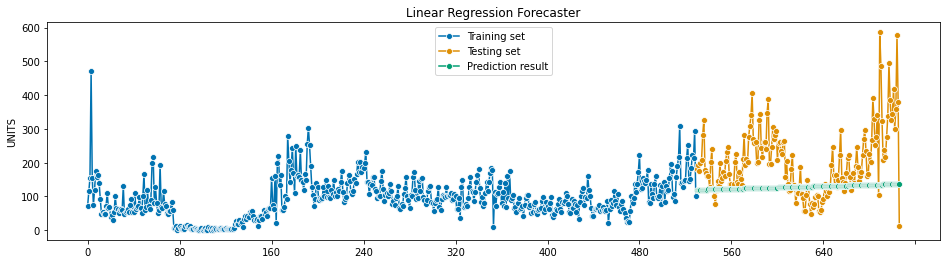

In [121]:
forecaster = TrendForecaster()
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=[d for d in range(1, y_test.shape[0]+1)])
_, ax = plot_series(y_train, y_test, y_pred, 
            labels=["Training set", "Testing set", "Prediction result"])
ax.set_title('Linear Regression Forecaster')

print(f"SCORE of Trend Forecaster: {forecaster.score(y_test)}")

SCORE of Polynomial Trend Forecaster: 0.40582610720995665


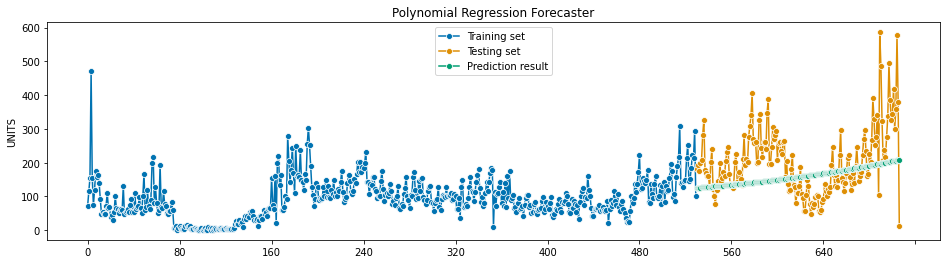

In [122]:
forecaster = PolynomialTrendForecaster(degree=3) # assume this is cubic polynomial
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=[d for d in range(1, y_test.shape[0]+1)])
_, ax = plot_series(y_train, y_test, y_pred, 
            labels=["Training set", "Testing set", "Prediction result"])
ax.set_title('Polynomial Regression Forecaster')

print(f"SCORE of Polynomial Trend Forecaster: {forecaster.score(y_test)}")

SCORE of Exponential Smoothing Forecaster: 0.6160203882518923


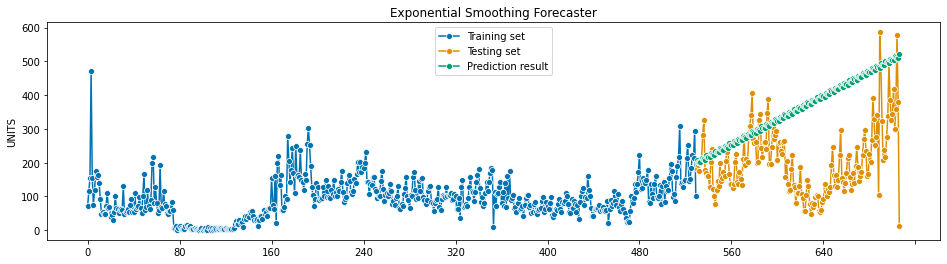

In [123]:
# We can see there were ups and downs in a year, so seasonal is additive;
# but the trend is roughly going up, so trend = 'add' too.
# Consider 4 quarters
forecaster = ExponentialSmoothing(trend='add', seasonal='add', sp=4)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=[d for d in range(1, y_test.shape[0]+1)])
_, ax = plot_series(y_train, y_test, y_pred, 
            labels=["Training set", "Testing set", "Prediction result"])
ax.set_title('Exponential Smoothing Forecaster')

print(f"SCORE of Exponential Smoothing Forecaster: {forecaster.score(y_test)}")

SCORE of Auto ARIMA Forecaster: 0.3971023579677143


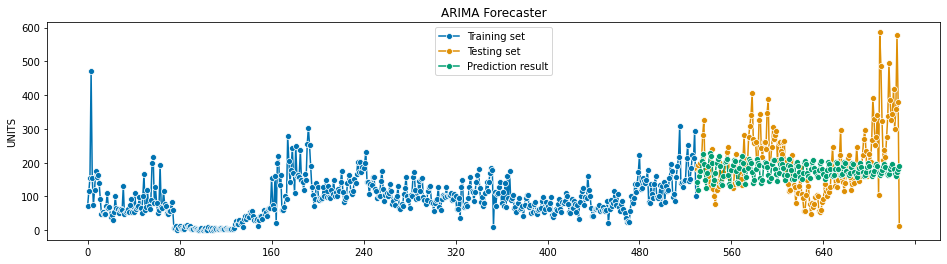

In [124]:
forecaster = AutoARIMA(sp=4, suppress_warnings=True)
forecaster.fit(y_train)

y_pred = forecaster.predict(fh=[d for d in range(1, y_test.shape[0]+1)])
_, ax = plot_series(y_train, y_test, y_pred, 
            labels=["Training set", "Testing set", "Prediction result"])
ax.set_title('ARIMA Forecaster')

print(f"SCORE of Auto ARIMA Forecaster: {forecaster.score(y_test)}")

### Parameter tuning

---
Now that we can see that Auto Arima is the best performer among all, we can use it as the basic model and optimize it by tuning its parameters.


In [74]:
from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, SlidingWindowSplitter, ForecastingGridSearchCV

In [141]:
forecaster = AutoARIMA(sp=4, suppress_warnings=True)
param_grid = {
    "d": [0, 1, 2, 3, 4],
    "start_q": [0, 1, 2, 3, 4],
    "start_p": [0, 1, 2, 3, 4]
}
cv = SlidingWindowSplitter(initial_window=60, window_length=20, fh=1)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="update", cv=cv, param_grid=param_grid
)

In [ ]:
from sktime.transformations.series.impute import Imputer

transformer = Imputer(method="mean")
y_train = transformer.fit_transform(y_train)

gscv.fit(y_train)

In [ ]:
y_pred = gscv.predict(fh=[d for d in range(1, y_test.shape[0]+1)])
_, ax = plot_series(y_train, y_test, y_pred, 
            labels=["Training set", "Testing set", "Prediction result"])
ax.set_title('Optimized ARIMA Forecaster')

print(f"SCORE of Optimized Auto ARIMA Forecaster: {gscv.score(y_test)}")

## Answer

In [98]:
start_date = 366 + 365 - y_train.shape[0]
end_date = start_date + 90 # length of Q1, 2022
q1_sales = gscv.predict(fh=[d for d in range(start_date, end_date)]).sum()

print(f"The sales of Nike SKU12345 is about {round(q1_sales, 1)}")

The sales of Nike SKU12345 is about 16073.0
